In [1]:
import numpy as np
import pandas as pd
import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../urbanbus_data/SER_0b91_start_aggregated.csv")

df = df.groupby(["Ride_start_datetime", "Bus_Service_Number", "Direction"], as_index=False)["Passenger_Count"].sum()
df["Ride_start_datetime"] = pd.to_datetime(df["Ride_start_datetime"], errors="coerce")

df.head()

,Ride_start_datetime,Bus_Service_Number,Direction,Passenger_Count
0,2017-10-01 00:00:00,SER_0b91,Start,2
1,2017-10-01 00:15:00,SER_0b91,Start,1
2,2017-10-01 05:45:00,SER_0b91,Start,21
3,2017-10-01 06:00:00,SER_0b91,Start,37
4,2017-10-01 06:15:00,SER_0b91,Start,48


In [3]:
# Basic datetime features
df['hour'] = df['Ride_start_datetime'].dt.hour
df['minute'] = df['Ride_start_datetime'].dt.minute
df['day'] = df['Ride_start_datetime'].dt.day
df['dayofweek'] = df['Ride_start_datetime'].dt.dayofweek
df['month'] = df['Ride_start_datetime'].dt.month
df['year'] = df['Ride_start_datetime'].dt.year
df['week_of_year'] = df['Ride_start_datetime'].dt.isocalendar().week

# Cyclic encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Weekend and holiday flag
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
china_holidays = holidays.country_holidays('CN')
df['is_holiday'] = df['Ride_start_datetime'].dt.date.apply(lambda x: x in china_holidays).astype(int)

cutoff_date = df['Ride_start_datetime'].max() - pd.Timedelta(days=28)
train_mask = df['Ride_start_datetime'] <= cutoff_date
test_mask = df['Ride_start_datetime'] > cutoff_date

peak_hours = df[train_mask].groupby('hour')['Passenger_Count'].sum().nlargest(2).index.tolist()
df['is_peak_hour'] = df['hour'].isin(peak_hours).astype(int)

# Lag features
for lag in [1, 2, 3, 4, 8, 12, 24]:
    df[f'lag_{lag}'] = df['Passenger_Count'].shift(lag)

# Rolling features
for window in [4, 8, 12, 24]:
    shifted_data = df['Passenger_Count'].shift(1)
    df[f'rolling_mean_{window}'] = shifted_data.rolling(window=window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = shifted_data.rolling(window=window, min_periods=1).std()

# Drop rows with NaNs from lag/rolling features
lag_roll_cols = [col for col in df.columns if col.startswith(('lag_', 'rolling_'))]
df = df.dropna(subset=lag_roll_cols).reset_index(drop=True)

In [4]:
cutoff_date = df['Ride_start_datetime'].max() - pd.Timedelta(days=28)
train_mask = df['Ride_start_datetime'] <= cutoff_date
test_mask = df['Ride_start_datetime'] > cutoff_date

X = df.drop(columns=["Ride_start_datetime", "Bus_Service_Number", "Direction", "Passenger_Count"])
y = df["Passenger_Count"]

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 11453
Test samples: 2095


In [5]:
tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    params = {
            "objective": "regression",
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "num_leaves": trial.suggest_int("num_leaves", 10, 30),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "min_child_samples": trial.suggest_int("min_child_samples", 20, 150),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8), 
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.5, 10.0, log=True), 
            "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 20.0, log=True),
            "random_state": 42,
            "verbose": -1
        }

    fold_mae = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        fold_mae.append(mae)

    return np.mean(fold_mae)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"\nBest MAE: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")


[I 2025-11-25 11:45:03,930] A new study created in memory with name: no-name-22112c0f-477d-4075-91d4-f223e3ea9b7b
Best trial: 0. Best value: 14.1739:   3%|▎         | 1/30 [00:00<00:25,  1.13it/s]

[I 2025-11-25 11:45:04,818] Trial 0 finished with value: 14.173917159544212 and parameters: {'n_estimators': 286, 'max_depth': 3, 'num_leaves': 19, 'learning_rate': 0.011392977339440275, 'min_child_samples': 85, 'subsample': 0.7959061898203321, 'colsample_bytree': 0.558056649883142, 'reg_alpha': 4.67800452984515, 'reg_lambda': 2.0602434570805412}. Best is trial 0 with value: 14.173917159544212.


Best trial: 1. Best value: 13.3578:   7%|▋         | 2/30 [00:01<00:27,  1.03it/s]

[I 2025-11-25 11:45:05,853] Trial 1 finished with value: 13.357838042805398 and parameters: {'n_estimators': 309, 'max_depth': 4, 'num_leaves': 17, 'learning_rate': 0.04902460284860176, 'min_child_samples': 136, 'subsample': 0.6029349857806444, 'colsample_bytree': 0.7736963507025312, 'reg_alpha': 9.083792168767395, 'reg_lambda': 19.589582474806722}. Best is trial 1 with value: 13.357838042805398.


Best trial: 2. Best value: 13.0972:  10%|█         | 3/30 [00:03<00:35,  1.30s/it]

[I 2025-11-25 11:45:07,536] Trial 2 finished with value: 13.097155399320988 and parameters: {'n_estimators': 314, 'max_depth': 5, 'num_leaves': 26, 'learning_rate': 0.046290335825596385, 'min_child_samples': 74, 'subsample': 0.5016376325760062, 'colsample_bytree': 0.616376120704349, 'reg_alpha': 5.441116938517435, 'reg_lambda': 3.34346581899171}. Best is trial 2 with value: 13.097155399320988.


Best trial: 2. Best value: 13.0972:  13%|█▎        | 4/30 [00:06<00:48,  1.85s/it]

[I 2025-11-25 11:45:10,229] Trial 3 finished with value: 13.2553702738777 and parameters: {'n_estimators': 461, 'max_depth': 6, 'num_leaves': 17, 'learning_rate': 0.05666332200219063, 'min_child_samples': 97, 'subsample': 0.63282922355958, 'colsample_bytree': 0.514763101549068, 'reg_alpha': 1.6384561862996714, 'reg_lambda': 8.688366297168603}. Best is trial 2 with value: 13.097155399320988.


Best trial: 2. Best value: 13.0972:  17%|█▋        | 5/30 [00:07<00:41,  1.67s/it]

[I 2025-11-25 11:45:11,582] Trial 4 finished with value: 13.121132628340638 and parameters: {'n_estimators': 169, 'max_depth': 8, 'num_leaves': 21, 'learning_rate': 0.0589072238247603, 'min_child_samples': 119, 'subsample': 0.6068881496516546, 'colsample_bytree': 0.7022277186200264, 'reg_alpha': 1.1099572639613942, 'reg_lambda': 6.895629028922308}. Best is trial 2 with value: 13.097155399320988.


Best trial: 2. Best value: 13.0972:  20%|██        | 6/30 [00:08<00:31,  1.31s/it]

[I 2025-11-25 11:45:12,203] Trial 5 finished with value: 13.325093793208248 and parameters: {'n_estimators': 193, 'max_depth': 3, 'num_leaves': 17, 'learning_rate': 0.09250252136732327, 'min_child_samples': 73, 'subsample': 0.6958310734273289, 'colsample_bytree': 0.6981671405020549, 'reg_alpha': 2.1317816879224383, 'reg_lambda': 4.077763432632609}. Best is trial 2 with value: 13.097155399320988.


Best trial: 2. Best value: 13.0972:  23%|██▎       | 7/30 [00:09<00:29,  1.28s/it]

[I 2025-11-25 11:45:13,407] Trial 6 finished with value: 13.267879286752622 and parameters: {'n_estimators': 434, 'max_depth': 3, 'num_leaves': 29, 'learning_rate': 0.03287458048791186, 'min_child_samples': 24, 'subsample': 0.5821403411006489, 'colsample_bytree': 0.6456474375265343, 'reg_alpha': 2.4750320119227127, 'reg_lambda': 2.2117610304941144}. Best is trial 2 with value: 13.097155399320988.


Best trial: 2. Best value: 13.0972:  27%|██▋       | 8/30 [00:10<00:25,  1.16s/it]

[I 2025-11-25 11:45:14,325] Trial 7 finished with value: 13.831099792655884 and parameters: {'n_estimators': 191, 'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.016050102748870435, 'min_child_samples': 58, 'subsample': 0.6037807591284998, 'colsample_bytree': 0.7804481622812172, 'reg_alpha': 5.020052038967027, 'reg_lambda': 11.429113847374317}. Best is trial 2 with value: 13.097155399320988.


Best trial: 8. Best value: 13.0587:  30%|███       | 9/30 [00:13<00:34,  1.63s/it]

[I 2025-11-25 11:45:16,981] Trial 8 finished with value: 13.05874015403183 and parameters: {'n_estimators': 451, 'max_depth': 8, 'num_leaves': 15, 'learning_rate': 0.02587597510924636, 'min_child_samples': 52, 'subsample': 0.6674862103560787, 'colsample_bytree': 0.7601532266849185, 'reg_alpha': 0.613258747240299, 'reg_lambda': 13.13454642991583}. Best is trial 8 with value: 13.05874015403183.


Best trial: 8. Best value: 13.0587:  33%|███▎      | 10/30 [00:14<00:32,  1.61s/it]

[I 2025-11-25 11:45:18,559] Trial 9 finished with value: 13.828031471633588 and parameters: {'n_estimators': 252, 'max_depth': 5, 'num_leaves': 21, 'learning_rate': 0.010882632249847604, 'min_child_samples': 60, 'subsample': 0.5819934671800797, 'colsample_bytree': 0.7637406356803976, 'reg_alpha': 1.0405344837224073, 'reg_lambda': 16.877801553081976}. Best is trial 8 with value: 13.05874015403183.


Best trial: 8. Best value: 13.0587:  37%|███▋      | 11/30 [00:16<00:33,  1.76s/it]

[I 2025-11-25 11:45:20,642] Trial 10 finished with value: 13.091890059185916 and parameters: {'n_estimators': 409, 'max_depth': 8, 'num_leaves': 11, 'learning_rate': 0.020980878024631822, 'min_child_samples': 28, 'subsample': 0.7108109138045455, 'colsample_bytree': 0.7005698104148852, 'reg_alpha': 0.6143462593926603, 'reg_lambda': 11.739068343351699}. Best is trial 8 with value: 13.05874015403183.


Best trial: 8. Best value: 13.0587:  40%|████      | 12/30 [00:18<00:31,  1.73s/it]

[I 2025-11-25 11:45:22,304] Trial 11 finished with value: 13.147374492325474 and parameters: {'n_estimators': 385, 'max_depth': 8, 'num_leaves': 10, 'learning_rate': 0.021107382382932114, 'min_child_samples': 21, 'subsample': 0.7046507360535165, 'colsample_bytree': 0.7120657326621717, 'reg_alpha': 0.5474663642712939, 'reg_lambda': 11.57818107503746}. Best is trial 8 with value: 13.05874015403183.


Best trial: 12. Best value: 13.0534:  43%|████▎     | 13/30 [00:20<00:31,  1.84s/it]

[I 2025-11-25 11:45:24,416] Trial 12 finished with value: 13.053412714206734 and parameters: {'n_estimators': 396, 'max_depth': 7, 'num_leaves': 13, 'learning_rate': 0.02426183604632541, 'min_child_samples': 41, 'subsample': 0.7196594385722304, 'colsample_bytree': 0.7300974829829819, 'reg_alpha': 0.5041841092349821, 'reg_lambda': 12.318845860094433}. Best is trial 12 with value: 13.053412714206734.


Best trial: 12. Best value: 13.0534:  47%|████▋     | 14/30 [00:23<00:34,  2.13s/it]

[I 2025-11-25 11:45:27,211] Trial 13 finished with value: 13.082039466536102 and parameters: {'n_estimators': 496, 'max_depth': 7, 'num_leaves': 14, 'learning_rate': 0.03210591666772336, 'min_child_samples': 52, 'subsample': 0.762575618307022, 'colsample_bytree': 0.7410809117306456, 'reg_alpha': 0.8185621281447186, 'reg_lambda': 13.720985176521546}. Best is trial 12 with value: 13.053412714206734.


Best trial: 12. Best value: 13.0534:  50%|█████     | 15/30 [00:25<00:31,  2.09s/it]

[I 2025-11-25 11:45:29,197] Trial 14 finished with value: 13.057902470577808 and parameters: {'n_estimators': 366, 'max_depth': 7, 'num_leaves': 14, 'learning_rate': 0.02319721871479035, 'min_child_samples': 47, 'subsample': 0.6610789258545846, 'colsample_bytree': 0.7971506717065957, 'reg_alpha': 0.513941803762455, 'reg_lambda': 7.281924769229813}. Best is trial 12 with value: 13.053412714206734.


Best trial: 12. Best value: 13.0534:  53%|█████▎    | 16/30 [00:27<00:28,  2.02s/it]

[I 2025-11-25 11:45:31,063] Trial 15 finished with value: 13.150924996334574 and parameters: {'n_estimators': 354, 'max_depth': 7, 'num_leaves': 13, 'learning_rate': 0.015717272941567068, 'min_child_samples': 39, 'subsample': 0.7431506544702674, 'colsample_bytree': 0.7905692251794065, 'reg_alpha': 1.4316223637762842, 'reg_lambda': 4.938102943956539}. Best is trial 12 with value: 13.053412714206734.


Best trial: 16. Best value: 12.9429:  57%|█████▋    | 17/30 [00:30<00:30,  2.34s/it]

[I 2025-11-25 11:45:34,133] Trial 16 finished with value: 12.942872768988172 and parameters: {'n_estimators': 363, 'max_depth': 7, 'num_leaves': 24, 'learning_rate': 0.016263480781242845, 'min_child_samples': 38, 'subsample': 0.6641319772401403, 'colsample_bytree': 0.6596931413719668, 'reg_alpha': 0.8268770203440806, 'reg_lambda': 7.625738835714699}. Best is trial 16 with value: 12.942872768988172.


Best trial: 16. Best value: 12.9429:  60%|██████    | 18/30 [00:31<00:25,  2.11s/it]

[I 2025-11-25 11:45:35,721] Trial 17 finished with value: 13.422932292357174 and parameters: {'n_estimators': 244, 'max_depth': 6, 'num_leaves': 24, 'learning_rate': 0.015262245584372556, 'min_child_samples': 103, 'subsample': 0.742936187461094, 'colsample_bytree': 0.6554482797130742, 'reg_alpha': 0.8518173764008404, 'reg_lambda': 8.927260139926545}. Best is trial 16 with value: 12.942872768988172.


Best trial: 16. Best value: 12.9429:  63%|██████▎   | 19/30 [00:32<00:19,  1.81s/it]

[I 2025-11-25 11:45:36,814] Trial 18 finished with value: 13.045259232615964 and parameters: {'n_estimators': 125, 'max_depth': 6, 'num_leaves': 24, 'learning_rate': 0.03801018541216408, 'min_child_samples': 37, 'subsample': 0.5450956062130113, 'colsample_bytree': 0.6024261656333455, 'reg_alpha': 3.020659866010697, 'reg_lambda': 5.727550450001609}. Best is trial 16 with value: 12.942872768988172.


Best trial: 16. Best value: 12.9429:  67%|██████▋   | 20/30 [00:33<00:15,  1.53s/it]

[I 2025-11-25 11:45:37,692] Trial 19 finished with value: 13.352546609845954 and parameters: {'n_estimators': 152, 'max_depth': 6, 'num_leaves': 24, 'learning_rate': 0.040243024002563334, 'min_child_samples': 147, 'subsample': 0.5282118114975173, 'colsample_bytree': 0.5902271540671626, 'reg_alpha': 3.5552809765403954, 'reg_lambda': 5.085726639068996}. Best is trial 16 with value: 12.942872768988172.


Best trial: 16. Best value: 12.9429:  70%|███████   | 21/30 [00:34<00:11,  1.25s/it]

[I 2025-11-25 11:45:38,300] Trial 20 finished with value: 13.330584962928777 and parameters: {'n_estimators': 110, 'max_depth': 4, 'num_leaves': 30, 'learning_rate': 0.03762831793736358, 'min_child_samples': 32, 'subsample': 0.5473095432626811, 'colsample_bytree': 0.5633010383560764, 'reg_alpha': 2.787506507525413, 'reg_lambda': 3.1790477495330522}. Best is trial 16 with value: 12.942872768988172.


Best trial: 21. Best value: 12.9427:  73%|███████▎  | 22/30 [00:37<00:13,  1.72s/it]

[I 2025-11-25 11:45:41,126] Trial 21 finished with value: 12.942734224246799 and parameters: {'n_estimators': 353, 'max_depth': 7, 'num_leaves': 24, 'learning_rate': 0.026385292810782605, 'min_child_samples': 36, 'subsample': 0.6815309674047554, 'colsample_bytree': 0.6510427833610853, 'reg_alpha': 1.7172421470146773, 'reg_lambda': 8.88441547687989}. Best is trial 21 with value: 12.942734224246799.


Best trial: 22. Best value: 12.9116:  77%|███████▋  | 23/30 [00:39<00:13,  1.95s/it]

[I 2025-11-25 11:45:43,604] Trial 22 finished with value: 12.911641374209823 and parameters: {'n_estimators': 328, 'max_depth': 6, 'num_leaves': 27, 'learning_rate': 0.02858956945477603, 'min_child_samples': 37, 'subsample': 0.6388217174948639, 'colsample_bytree': 0.6691894138242961, 'reg_alpha': 1.8248964175342017, 'reg_lambda': 5.501611472720368}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116:  80%|████████  | 24/30 [00:42<00:13,  2.18s/it]

[I 2025-11-25 11:45:46,334] Trial 23 finished with value: 13.007742271980689 and parameters: {'n_estimators': 339, 'max_depth': 7, 'num_leaves': 27, 'learning_rate': 0.017153099674920277, 'min_child_samples': 68, 'subsample': 0.6391493425452736, 'colsample_bytree': 0.6641354241815601, 'reg_alpha': 1.7802808612299603, 'reg_lambda': 8.55497143169829}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116:  83%|████████▎ | 25/30 [00:44<00:11,  2.27s/it]

[I 2025-11-25 11:45:48,813] Trial 24 finished with value: 12.932563358238562 and parameters: {'n_estimators': 286, 'max_depth': 7, 'num_leaves': 27, 'learning_rate': 0.028196696900542103, 'min_child_samples': 44, 'subsample': 0.6665887768926166, 'colsample_bytree': 0.6283383189101704, 'reg_alpha': 1.258815391995164, 'reg_lambda': 6.245166590900072}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116:  87%|████████▋ | 26/30 [00:46<00:08,  2.17s/it]

[I 2025-11-25 11:45:50,731] Trial 25 finished with value: 13.012467123185898 and parameters: {'n_estimators': 263, 'max_depth': 6, 'num_leaves': 28, 'learning_rate': 0.02796906220845772, 'min_child_samples': 63, 'subsample': 0.6324891380235244, 'colsample_bytree': 0.6296370833384998, 'reg_alpha': 1.4364479386024434, 'reg_lambda': 5.551165810521382}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116:  90%|█████████ | 27/30 [00:49<00:06,  2.19s/it]

[I 2025-11-25 11:45:52,991] Trial 26 finished with value: 13.036962643707115 and parameters: {'n_estimators': 326, 'max_depth': 7, 'num_leaves': 26, 'learning_rate': 0.029324573306255694, 'min_child_samples': 84, 'subsample': 0.6842477727838144, 'colsample_bytree': 0.6824513320887506, 'reg_alpha': 1.9431063316447925, 'reg_lambda': 4.611669228430689}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116:  93%|█████████▎| 28/30 [00:51<00:04,  2.19s/it]

[I 2025-11-25 11:45:55,174] Trial 27 finished with value: 12.943073875848997 and parameters: {'n_estimators': 288, 'max_depth': 6, 'num_leaves': 22, 'learning_rate': 0.019518098945903475, 'min_child_samples': 30, 'subsample': 0.6861424546673885, 'colsample_bytree': 0.6289516940709328, 'reg_alpha': 1.2532927684220818, 'reg_lambda': 3.9155961784538125}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116:  97%|█████████▋| 29/30 [00:53<00:02,  2.27s/it]

[I 2025-11-25 11:45:57,641] Trial 28 finished with value: 13.45762627665595 and parameters: {'n_estimators': 220, 'max_depth': 8, 'num_leaves': 26, 'learning_rate': 0.012870625886835439, 'min_child_samples': 48, 'subsample': 0.6437916556530446, 'colsample_bytree': 0.577946700400035, 'reg_alpha': 3.4547550011962276, 'reg_lambda': 10.077273750753879}. Best is trial 22 with value: 12.911641374209823.


Best trial: 22. Best value: 12.9116: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]

[I 2025-11-25 11:45:59,166] Trial 29 finished with value: 13.176779861606969 and parameters: {'n_estimators': 281, 'max_depth': 5, 'num_leaves': 30, 'learning_rate': 0.06575353151629505, 'min_child_samples': 87, 'subsample': 0.7709543291120537, 'colsample_bytree': 0.5331967958605971, 'reg_alpha': 1.4616251803326274, 'reg_lambda': 6.274298125915096}. Best is trial 22 with value: 12.911641374209823.

Best MAE: 12.9116
Best parameters: {'n_estimators': 328, 'max_depth': 6, 'num_leaves': 27, 'learning_rate': 0.02858956945477603, 'min_child_samples': 37, 'subsample': 0.6388217174948639, 'colsample_bytree': 0.6691894138242961, 'reg_alpha': 1.8248964175342017, 'reg_lambda': 5.501611472720368}


In [6]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    if np.sum(mask) == 0:
        return 0.0
    return np.mean(2.0 * np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

def evaluate_model(y_true, y_pred, set_name="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{set_name} Performance:")
    print(f"  MAE:   {mae:.4f}")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  R²:    {r2:.4f}")
    print(f"  MAPE:  {mape*100:.2f}%")
    print(f"  sMAPE: {smape:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'sMAPE': smape}

best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = -1

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

train_metrics = evaluate_model(y_train, y_pred_train, "Train")
test_metrics = evaluate_model(y_test, y_pred_test, "Test")


Train Performance:
  MAE:   10.8846
  RMSE:  14.2025
  R²:    0.8692
  MAPE:  21.62%
  sMAPE: 18.80%

Test Performance:
  MAE:   12.3010
  RMSE:  16.3120
  R²:    0.8514
  MAPE:  25.55%
  sMAPE: 20.84%


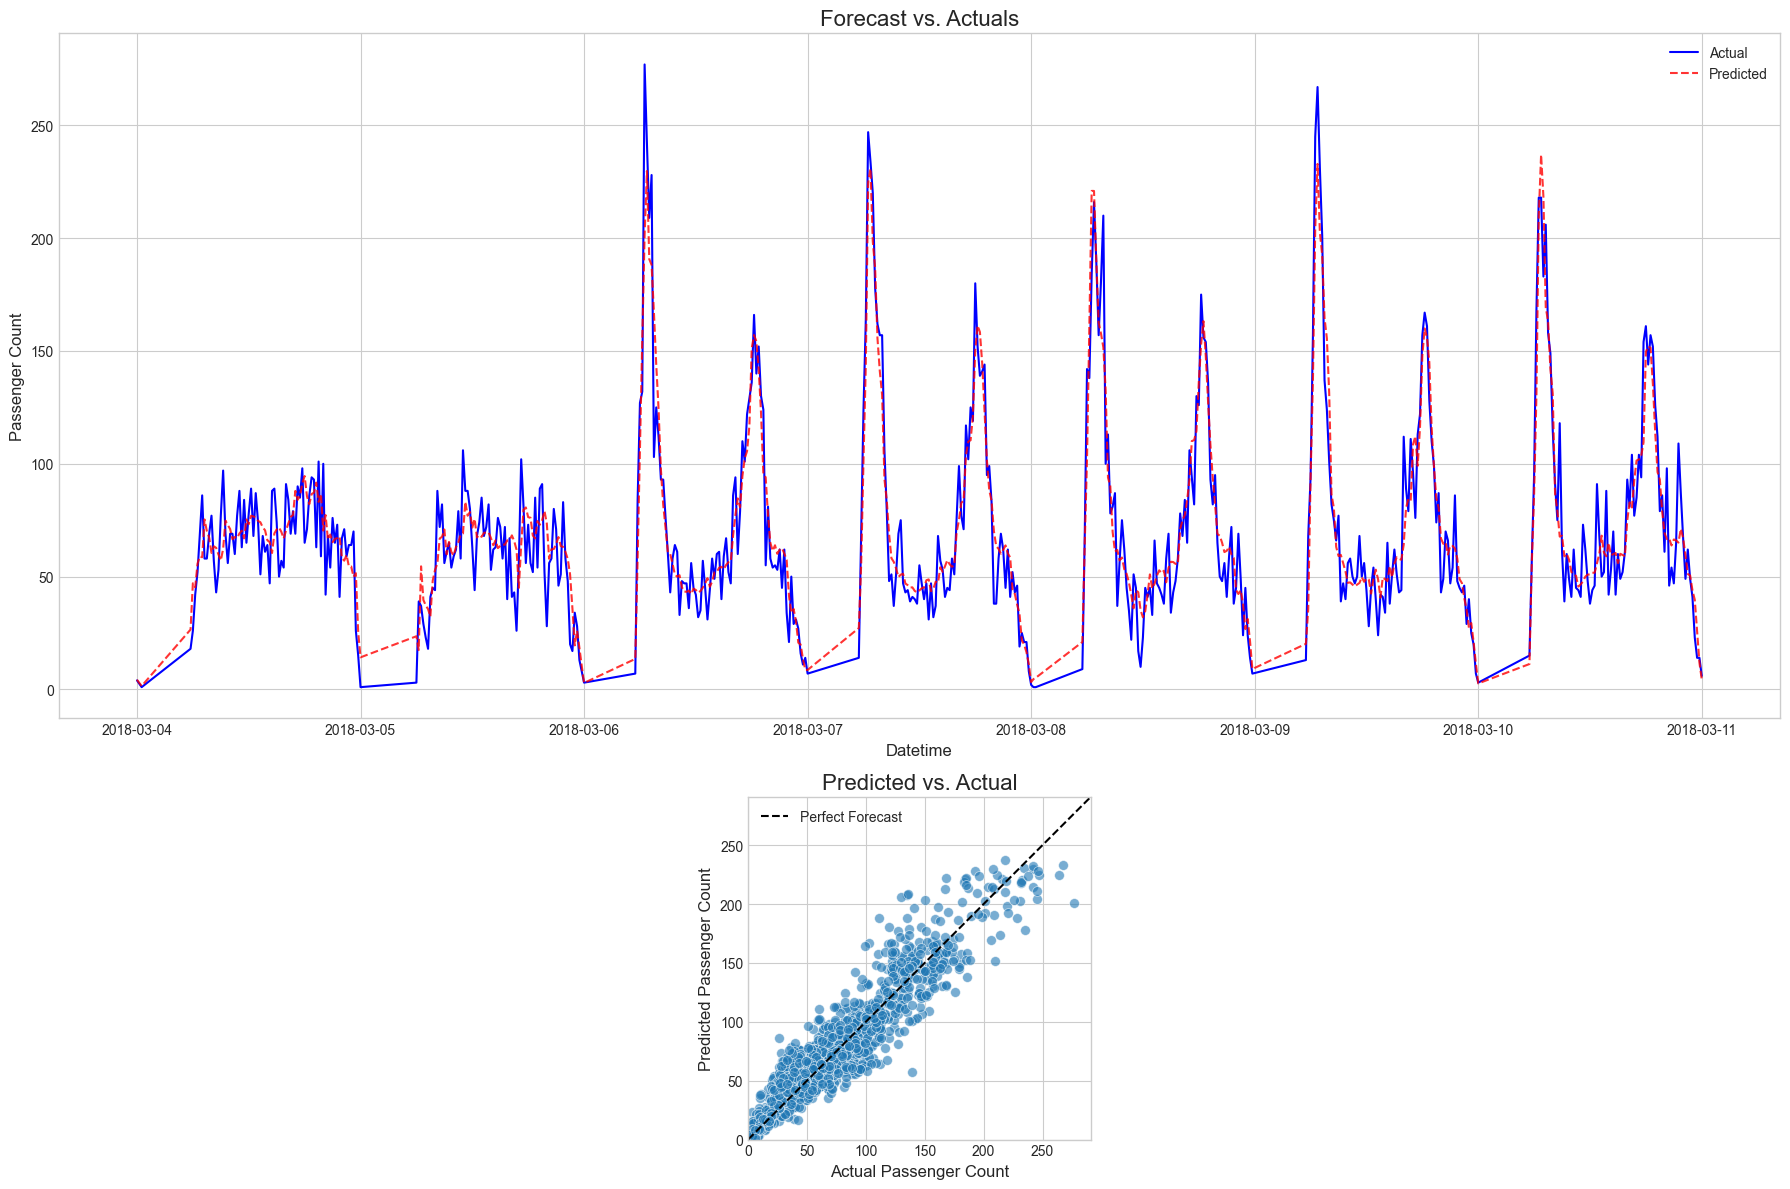

In [9]:
results_df = pd.DataFrame({
    'Ride_start_datetime': df[test_mask]['Ride_start_datetime'],
    'Actual': y_test,
    'Predicted': y_pred_test
}).set_index('Ride_start_datetime')


sample_end_date = results_df.index.min() + pd.Timedelta(days=7)
results_sample = results_df[results_df.index <= sample_end_date]

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [2, 1]})

sns.lineplot(data=results_sample, x=results_sample.index, y='Actual', ax=axes[0], label='Actual', color='blue', linewidth=1.5)
sns.lineplot(data=results_sample, x=results_sample.index, y='Predicted', ax=axes[0], label='Predicted', color='red', alpha=0.8, linestyle='--')
axes[0].set_title(f'Forecast vs. Actuals', fontsize=16)
axes[0].set_ylabel('Passenger Count', fontsize=12)
axes[0].set_xlabel('Datetime', fontsize=12)
axes[0].legend()

max_val = max(results_df['Actual'].max(), results_df['Predicted'].max()) * 1.05
sns.scatterplot(data=results_df, x='Actual', y='Predicted', ax=axes[1], alpha=0.6, s=50)
sns.lineplot(x=[0, max_val], y=[0, max_val], color='black', linestyle='--', ax=axes[1], label='Perfect Forecast')
axes[1].set_title(f'Predicted vs. Actual', fontsize=16)
axes[1].set_xlabel('Actual Passenger Count', fontsize=12)
axes[1].set_ylabel('Predicted Passenger Count', fontsize=12)
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend()
axes[1].set_xlim(0, max_val)
axes[1].set_ylim(0, max_val)

plt.tight_layout()
plt.show()

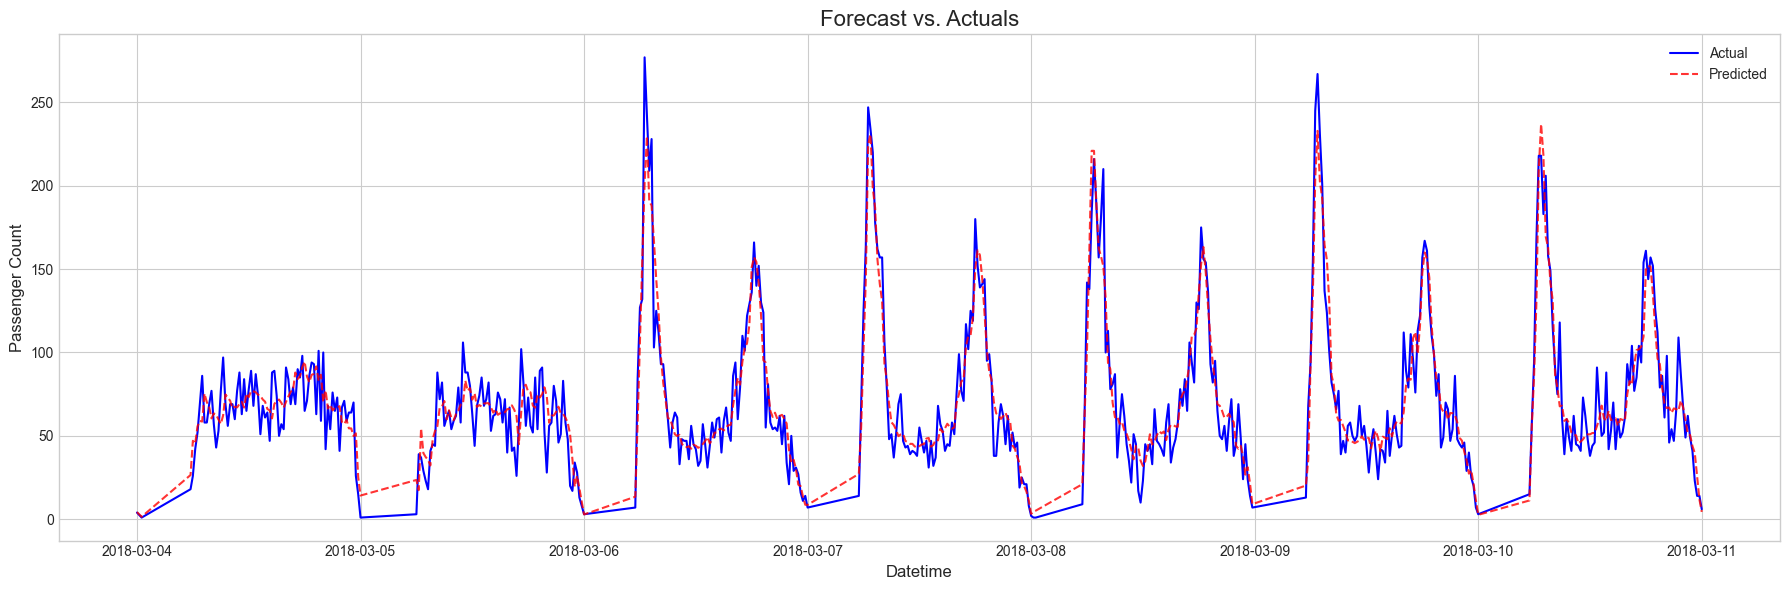

In [10]:
# Prepare sample week of data
results_df = pd.DataFrame({
    'Ride_start_datetime': df[test_mask]['Ride_start_datetime'],
    'Actual': y_test,
    'Predicted': y_pred_test
}).set_index('Ride_start_datetime')

sample_end_date = results_df.index.min() + pd.Timedelta(days=7)
results_sample = results_df[results_df.index <= sample_end_date]

# --- Plot: Forecast vs Actuals (ONLY THIS) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 6))

sns.lineplot(
    data=results_sample,
    x=results_sample.index,
    y='Actual',
    label='Actual',
    color='blue',
    linewidth=1.5
)

sns.lineplot(
    data=results_sample,
    x=results_sample.index,
    y='Predicted',
    label='Predicted',
    color='red',
    alpha=0.8,
    linestyle='--'
)

plt.title('Forecast vs. Actuals', fontsize=16)
plt.ylabel('Passenger Count', fontsize=12)
plt.xlabel('Datetime', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
